### install

In [ ]:
pip install wfdb

In [9]:
pip install sklearn

  Using cached sklearn-0.0.post11.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2368 sha256=51219945f2b852fc2c53fa19c32da8a268bfb2162ff498a4b47a035e05bf7622
  Stored in directory: /root/.cache/pip/wheels/70/dd/c1/c0e70c6a6ea95f09025000ece03b995c41d1214b65301ff5fe
Successfully built sklearn
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a confor

In [10]:
pip install lightgbm

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.0 MB/s eta 0:00:00:00:0100:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install xgboost cudatoolkit=10.1 #xgboost의 gpu모델 사용관련 코드

ERROR: Invalid requirement: 'cudatoolkit=10.1'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.9 MB/s eta 0:00:00a 0:00:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


### import

In [14]:
import ast
import wfdb
import h5py

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.decomposition import PCA         
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb  

### 데이터 읽기
- input 요소 있음. 콜렙은 c, 데스크탑은 D, 서버에서는 s 라고 치면됨. 대문자 소문자 상관없음.

In [15]:
while True:
    data_location = input("Are you using the colab? Y/N" )

    if data_location.lower() == 'y':
        # Google Colab
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = '/content/drive/MyDrive/ds8/harbud/ecg' + '/'
        base_path_ptb = '/content/drive/MyDrive/ds8/harbud/ecg/ptb_xl_data' + '/'
        base_path_shp = '/content/drive/MyDrive/ds8/harbud/ecg/sph_data' + '/'
        break
    elif data_location.lower() == 'n':
        res = os.getcwd()
        base_path = os.path.join(res)
        base_path_ptb = os.path.join(res, 'ptb_xl_data') + '/'
        base_path_shp = os.path.join(res, 'sph_data') + '/'
        break
    else:
        print('입력값이 올바르지 않습니다. 다시 입력하세요.')


In [16]:
df_ptb_origin = pd.read_csv(base_path_ptb + 'ptbxl_database.csv', encoding='utf-8',index_col='ecg_id')
df_sph_origin = pd.read_csv(base_path_shp + 'metadata.csv', encoding='utf-8', index_col='ECG_ID')

### Ptb_xl의 심박수 데이터 lead1 추출 -> .csv 파일로만듬
 - 신호 및 의료 데이터에 대한 읽기 및 쓰기 기능을 제공하는 wfdb를 이용해서 데이터를 읽음.
 - 각 데이터는 PTBXL_DATABASE에 컬럼으로 만들어 져 있음. 100HZ와 500HZ중 500HZ사용. (테스트 데이터와 맞추기위해)
 - df_lead1.to_csv 로 저장해서 사용하기 편하게 만들어둠

In [ ]:
# #신호 데이터 읽기
# filenames = df_ptb_origin.filename_hr.tolist()    #filename_lr은 100Hz로 저장되어 있는 신호 데이터 파일 경로이고, filename_hr은 500Hz, 여기서는 500Hz만 사용

# df_lead1= pd.DataFrame()

# for ptb_index in tqdm(range(len(df_ptb_origin.index)), 'time'):
#     signal, meta = wfdb.rdsamp(base_path_ptb + filenames[ptb_index])
#     lead1 = signal[:, 0]
#     df_lead1 = pd.concat([df_lead1, pd.DataFrame(lead1).T], axis=0)
# df_lead1.index = df_ptb_origin.index[:]

# df_lead1.to_csv(base_path + r'\custom_file\ashton_ptb_lead1.csv', encoding='UTF-8')


### shp의 심박수 데이터 leead1 추출 -> .csv 파일로만듬

In [ ]:
# filenames = sorted(glob(base_path + r"sph_data\records_sph\*.h5"))

# df_sph_origin['filename'] = filenames

# df_lead1_sph = pd.DataFrame()

# for shp_index in tqdm(range(len(df_sph_origin.index)), 'time'):
# # for shp_index in tqdm(range(0, 3), desc='time'):
#     filename = df_sph_origin.filename.tolist()[shp_index]

#     with h5py.File(filename, 'r') as f:
#         signal = f['ecg'][:]
#     lead1 = signal[0, :]

#     if lead1.shape[0] == 5000:
#         lead1_df = pd.DataFrame(lead1)
#     # 데이터의 길이가 5000보다 큰 경우, 연속적인 5000개의 데이터를 랜덤하게 선택
#     else:
#         start_idx = np.random.randint(0, lead1.shape[0] - 4999)  # 마지막 5000개를 포함할 수 있도록 인덱스 설정
#         lead1_df = pd.DataFrame(lead1[start_idx:start_idx+5000])

#     df_lead1_sph = pd.concat([df_lead1_sph, pd.DataFrame(lead1_df).T], axis=0, ignore_index=True)

# df_lead1_sph.index = df_sph_origin.index

# df_lead1_sph.to_csv(base_path + r'\custom_file\ashton_sph_lead1.csv', encoding='UTF-8')


[with문 설명]

with 문은 파일이나 네트워크 연결과 같은 리소스를 사용하는 동안에는 해당 리소스를 안전하게 사용하기 위한 구문입니다. 

with 문을 사용하면 파일이나 네트워크 연결을 열고 사용한 후 자동으로 닫아주는 코드를 작성할 필요가 없습니다.

- h5py.File(filename, 'r')는 HDF5 파일을 '읽기 전용' 모드로 엽니다.
- with 문을 사용하면 블록 안에서 파일을 사용한 후 블록을 벗어나면 파일이 자동으로 닫힙니다. 따라서 파일을 명시적으로 닫아줄 필요가 없습니다.
signal = f['ecg'][:].T는 HDF5 파일에서 'ecg'라는 데이터셋을 가져와서 해당 데이터를 NumPy 배열로 읽어옵니다. 마지막으로 .T는 전치(transpose)를 수행하여 배열의 행과 열을 바꿉니다.
- with 문은 예외 발생 시에도 안전하게 리소스를 정리하는 데 도움을 줍니다. 파일이나 네트워크 연결과 같은 리소스를 사용한 후에는 명시적으로 닫아주는 것이 좋은 프로그래밍 습관이지만, with 문을 사용하면 이를 누락하는 실수를 방지할 수 있습니다.

### 위를 통해서 만들어진 .csv 파일 읽기

In [17]:
df_ptb_lead1 = pd.read_csv(base_path + '/custom_file/ashton_ptb_lead1.csv', index_col=0)

df_sph_lead1 = pd.read_csv(base_path + '/custom_file/ashton_sph_lead1.csv', index_col=0)

### PTB_xl, SHP 데이터 라벨링

In [18]:
#PTB 라벨링

#scp_codes 에서 AFIB에 해당하는 것에 대해서 라벨링
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: list(x.keys()))
df_ptb_origin['label'] = df_ptb_origin.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

print('df_ptb_origin : ',df_ptb_origin.label.value_counts())
print('-'*15)

#SHP 라벨링

# df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(lambda x: 1 if '50' in str(x) else 0) - 기존에 잘못된
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(check_contains_50).astype(int)


print('df_sph_origin : ',df_sph_origin.label.value_counts())

df_ptb_origin :  label
0    20285
1     1514
Name: count, dtype: int64
---------------
df_sph_origin :  label
0    25095
1      675
Name: count, dtype: int64


### age, sex, label 컬럼과 심박수 데이터 합치기

In [19]:
df_ptb = pd.concat([df_ptb_origin[['age', 'sex', 'label']], df_ptb_lead1], axis=1)

df_sph_lead1.index = df_sph_origin.index
df_sph = pd.concat([df_sph_origin[['Age', 'Sex', 'label']], df_sph_lead1], axis=1)


### 'age', 'sex' 사용 여부에 따른 train, val, test 
- input 요소 있음.
  - 심박수 데이터만 사용할려면 : N
  - age, sex데이터를 함께 사용하려면 : Y
  
(답변시 대문자 소문자 상관없음)

In [20]:
while True:
    age_sex_col=input("Are you using the [age] and [sex] columns? Y/N" )

    if age_sex_col.lower() == 'y':

        X = df_ptb.drop(['label'], axis=1)
        y = df_ptb['label']
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

        X_sph_test = df_sph.drop(['label'], axis=1)
        y_sph_test = df_sph['label']
        break

    elif age_sex_col.lower() == 'n':

        X = df_ptb.drop(['age', 'sex', 'label'], axis=1)
        y = df_ptb['label']
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

        X_sph_test = df_sph.drop(['Age', 'Sex', 'label'], axis=1)
        y_sph_test = df_sph['label']
        break
    else:
        print('입력값이 올바르지 않습니다. 다시 입력하세요.')


In [21]:

# X_train, y_train은 훈련 데이터의 특징과 레이블을 나타냅니다.
# 예를 들어, X_train은 (샘플 수, 특징 수)의 2D 배열이어야 합니다.
# y_train은 이진 분류의 경우 0 또는 1 값을 가지는 1D 배열이어야 합니다.

# 언더샘플링을 위한 객체 생성
rus = RandomUnderSampler(random_state=42)
print("클래스 분포 (언더샘플링 전):", Counter(X_train))
print("클래스 분포 (언더샘플링 전):", Counter(y_train))
# 언더샘플링 적용
X_train, y_train = rus.fit_resample(X_train, y_train)
X_val, y_val = rus.fit_resample(X_val, y_val)
X_test, y_test = rus.fit_resample(X_test, y_test)
X_sph_test, y_sph_test = rus.fit_resample(X_sph_test, y_sph_test)

# 언더샘플링 전과 후의 클래스 분포 확인
print("클래스 분포 (언더샘플링 후):", Counter(X_train))
print("클래스 분포 (언더샘플링 후):", Counter(y_train))

클래스 분포 (언더샘플링 전): Counter({'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 1, '29': 1, '30': 1, '31': 1, '32': 1, '33': 1, '34': 1, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 1, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 1, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 1, '66': 1, '67': 1, '68': 1, '69': 1, '70': 1, '71': 1, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 1, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 1, '97': 1, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 1, '105': 1, '106': 1, '107': 1, '10

In [22]:
scaler_std = StandardScaler()
X_train_scaler_std = scaler_std.fit_transform(X_train)
X_val_scaler_std = scaler_std.transform(X_val)
X_test_scaler_std = scaler_std.transform(X_test)
X_sph_test_scaler_std = scaler_std.transform(X_sph_test)


In [24]:
pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaler_std)

X_val_pca = pca.transform(X_val_scaler_std)
X_test_pca = pca.transform(X_test_scaler_std)
X_sph_test_pca = pca.transform(X_sph_test_scaler_std)


### 오리지널 데이터 전처리
 - sph의 성별데이터 F,M 

### 모델

In [27]:
xgb = XGBClassifier(n_estimators=250,
                    max_depth=15,
                    colsample_bynode=0.75,
                    # colsample_bytree=0.5,
                    # colsample_bylevel=0.5,
                    reg_lambda=1,
                    learning_rate=1e-2,
                    random_state=22,
                    n_jobs=-1)

model = xgb

In [ ]:


# # GPU를 사용하기 위해 환경 변수 설정
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 사용할 GPU의 번호

# # XGBoost 분류기 초기화
# xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)  # GPU 사용 설정

# # 튜닝할 하이퍼파라미터 설정
# param_grid = {
#     'n_estimators': [300, 500],
#     'max_depth': [10, 20, 30],
#     'colsample_bynode': [0.5, 0.75, 1.0],
#     'reg_lambda': [0.1, 1, 10],
#     'learning_rate': [1e-2, 1e-3, 1e-4]
# }

# # 그리드 탐색 수행
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적의 하이퍼파라미터:", grid_search.best_params_)

# # 테스트 세트에서 모델 평가
# best_model = grid_search.best_estimator_
# y_val_pred = best_model.predict(X_val)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [28]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.75,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, random_state=22, ...)

### Ptb_xl의 Val 진행( 10% 데이터)

In [29]:
# 모델로 예측 수행
y_val_pred = model.predict(X_val)

In [30]:
cross_entropy = log_loss(y_val, y_val_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 11.145077034792804


In [31]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_val, y_val_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_val, y_val_pred)
print(f"F1 Score: {f1}")

# AUROC
y_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[107  45]
 [ 49 103]]
Sensitivity (Recall): 0.6858974358974359
Specificity: 0.6959459459459459
Precision: 0.6959459459459459
F1 Score: 0.6866666666666666
AUROC: 0.7218663434903048
Precision-Recall AUC: 0.6734806219149494


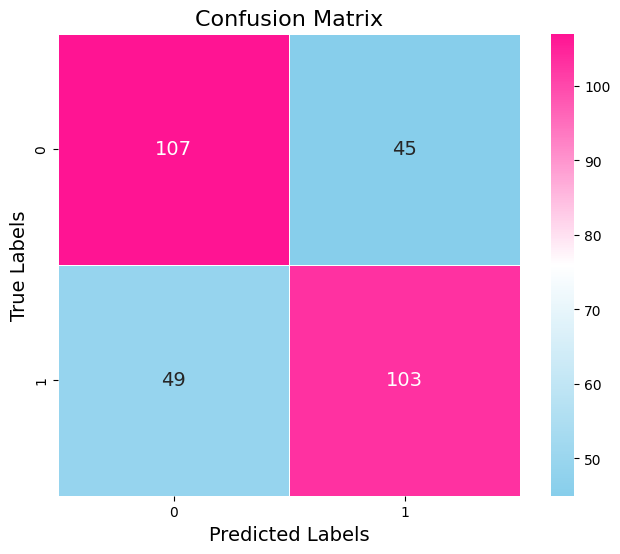

In [32]:
from matplotlib.colors import LinearSegmentedColormap

# 예측과 정답을 기반으로 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_val, y_val_pred)

# 사용자 정의 그라데이션 컬러맵 생성
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['skyblue', 'white', '#FF1493'], N=256)

# Matplotlib을 사용하여 Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, 
            annot_kws={"size": 14}, linewidths=.5, square=True)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

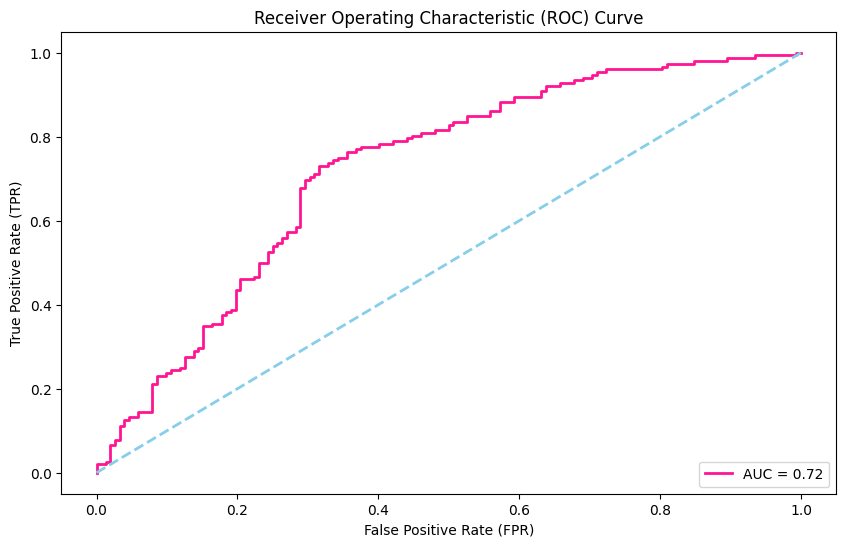

In [33]:

# 예측 확률 얻기
y_val_pred = model.predict_proba(X_val)[:, 1]

# FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#FF1493', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Ptb_xl의 test 진행( 10% 데이터)

In [43]:
# 모델로 예측 수행
y_test_pred = model.predict(X_test)

In [35]:
cross_entropy = log_loss(y_test, y_test_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 14.441331324778726


In [36]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_test, y_test_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1}")

# AUROC
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[97 54]
 [67 84]]
Sensitivity (Recall): 0.5914634146341463
Specificity: 0.6086956521739131
Precision: 0.6086956521739131
F1 Score: 0.5813148788927336
AUROC: 0.6633042410420595
Precision-Recall AUC: 0.6413644203626492


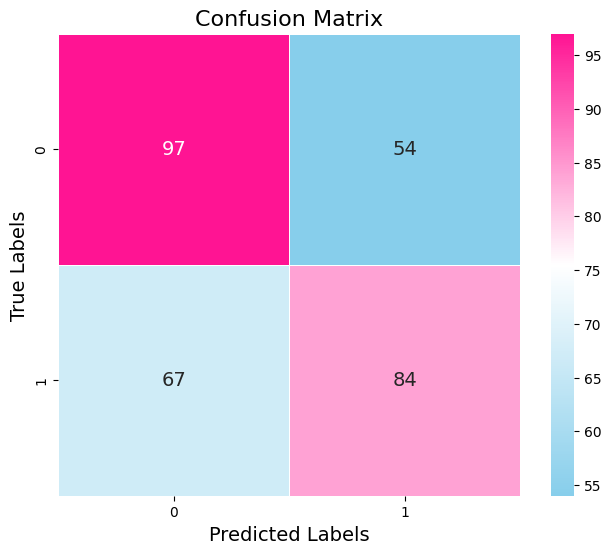

In [37]:
from matplotlib.colors import LinearSegmentedColormap

# 예측과 정답을 기반으로 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 사용자 정의 그라데이션 컬러맵 생성
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['skyblue', 'white', '#FF1493'], N=256)

# Matplotlib을 사용하여 Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, 
            annot_kws={"size": 14}, linewidths=.5, square=True)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

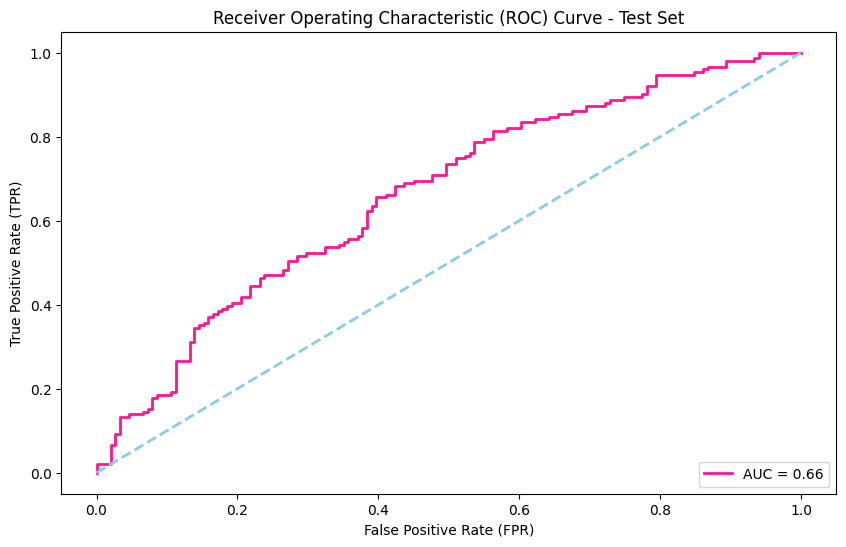

In [44]:
# 예측 확률 얻기
y_test_pred = model.predict_proba(X_test)[:, 1]

# FPR, TPR 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

# AUC 계산
roc_auc_test = auc(fpr_test, tpr_test)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='#FF1493', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

### SPH 데이터 테스트 진행

In [39]:
# 모델로 예측 수행
y_sph_pred = model.predict(X_sph_test)

In [40]:
cross_entropy = log_loss(y_sph_test, y_sph_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 15.138334423429203


In [41]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_sph_test, y_sph_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_sph_test, y_sph_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_sph_test, y_sph_pred)
print(f"F1 Score: {f1}")

# AUROC
y_sph_prob = model.predict_proba(X_sph_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_sph_test, y_sph_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_sph_test, y_sph_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[352 323]
 [244 431]]
Sensitivity (Recall): 0.5906040268456376
Specificity: 0.5716180371352785
Precision: 0.5716180371352785
F1 Score: 0.603219034289713
AUROC: 0.6063714677640604
Precision-Recall AUC: 0.5787129608817954


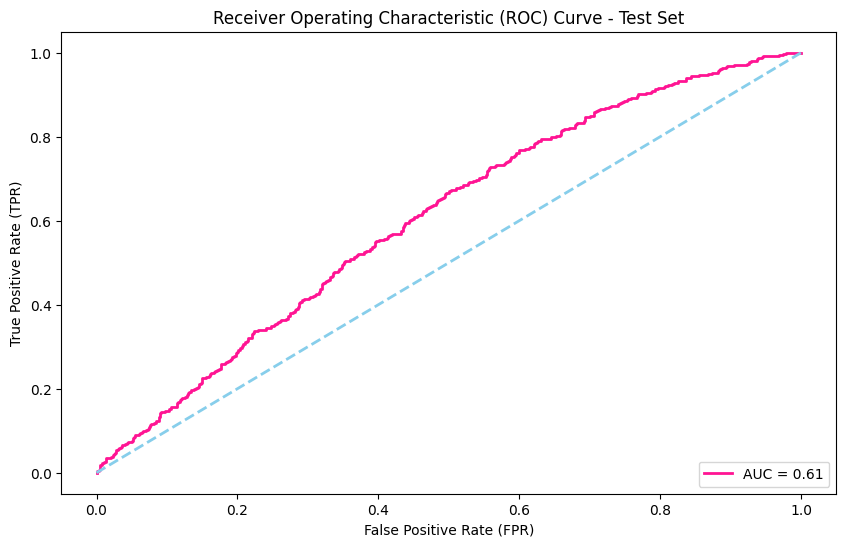

In [42]:
# 예측 확률 얻기
y_test_pred = model.predict_proba(X_sph_test)[:, 1]

# FPR, TPR 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_sph_test, y_test_pred)

# AUC 계산
roc_auc_test = auc(fpr_test, tpr_test)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='#FF1493', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()
